In [22]:
import re
import nltk
import distance
import numpy as np
import pandas as pd
import networkx as nx
import tensorflow as K

from fuzzywuzzy import fuzz
from keras.models import Model
from nltk.corpus import stopwords
from collections import defaultdict
from keras.layers.core import Lambda
from keras.layers.noise import GaussianNoise
from keras.preprocessing.text import Tokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from keras.layers.advanced_activations import PReLU
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
from keras.layers.merge import concatenate, add, multiply
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.feature_extraction.text import CountVectorizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Conv1D, GlobalAveragePooling1D, Bidirectional

## Changed from 0 --> 1 
np.random.seed(1)
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")
NB_CORES = 10
FREQ_UPPER_BOUND = 100
NEIGHBOR_UPPER_BOUND = 5
WNL = WordNetLemmatizer()
MAX_SEQUENCE_LENGTH = 32
MIN_WORD_OCCURRENCE = 100
REPLACE_WORD = "memento"
EMBEDDING_DIM = 300
NUM_FOLDS = 12
BATCH_SIZE = 256
EMBEDDING_FILE = "glove.840B.300d.txt"

In [23]:
### Added this to my code 
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/spencerrafii/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
def preprocess_nlp(string):
    string = string.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
        .replace("€", " euro ").replace("'ll", " will").replace("=", " equal ").replace("+", " plus ")
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    string = re.sub(r"([0-9]+)000000", r"\1m", string)
    string = re.sub(r"([0-9]+)000", r"\1k", string)
    return string

def preprocess_model(string):
    string = string.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
        .replace("€", " euro ").replace("'ll", " will").replace("=", " equal ").replace("+", " plus ")
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    string = re.sub(r"([0-9]+)000000", r"\1m", string)
    string = re.sub(r"([0-9]+)000", r"\1k", string)
    string = ' '.join([cutter(w) for w in string.split()])
    return string

def get_token_features(q1, q2):
    token_features = [0.0] * 10

    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])

    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])

    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))

    token_features[0] = common_word_count / (
        min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (
        max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (
        min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (
        max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (
        min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (
        max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2
    return token_features

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
    
def extract_features_nlp(df):
    df = df.copy()
    df["question1"] = df["question1"].fillna("").apply(preprocess_nlp)
    df["question2"] = df["question2"].fillna("").apply(preprocess_nlp)

    print("token features...")
    token_features = df.apply(
        lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    df["cwc_min"] = list(map(lambda x: x[0], token_features))
    df["cwc_max"] = list(map(lambda x: x[1], token_features))
    df["csc_min"] = list(map(lambda x: x[2], token_features))
    df["csc_max"] = list(map(lambda x: x[3], token_features))
    df["ctc_min"] = list(map(lambda x: x[4], token_features))
    df["ctc_max"] = list(map(lambda x: x[5], token_features))
    df["last_word_eq"] = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"] = list(map(lambda x: x[8], token_features))
    df["mean_len"] = list(map(lambda x: x[9], token_features))

    print("fuzzy features..")
    df["token_set_ratio"] = df.apply(
        lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    df["token_sort_ratio"] = df.apply(
        lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]),
        axis=1)
    df["fuzz_ratio"] = df.apply(
        lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"] = df.apply(
        lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"] = df.apply(
        lambda x: get_longest_substr_ratio(x["question1"], x["question2"]),
        axis=1)
    return df

def create_question_hash(train_df, test_df):
    train_qs = np.dstack([train_df["question1"],
                          train_df["question2"]]).flatten()
    test_qs = np.dstack([test_df["question1"], test_df["question2"]]).flatten()
    all_qs = np.append(train_qs, test_qs)
    all_qs = pd.DataFrame(all_qs)[0].drop_duplicates()
    all_qs.reset_index(inplace=True, drop=True)
    question_dict = pd.Series(
        all_qs.index.values, index=all_qs.values).to_dict()
    return question_dict

def get_hash(df, hash_dict):
    df = df.copy()
    df["qid1"] = df["question1"].map(hash_dict)
    df["qid2"] = df["question2"].map(hash_dict)
    return df.drop(["question1", "question2"], axis=1)

def get_kcore_dict(df):
    df = df.copy()
    g = nx.Graph()
    g.add_nodes_from(df.qid1)
    edges = list(df[["qid1", "qid2"]].to_records(index=False))
    g.add_edges_from(edges)
    g.remove_edges_from(g.selfloop_edges())
    df_output = pd.DataFrame(data=g.nodes(), columns=["qid"])
    df_output["kcore"] = 0
    for k in range(2, NB_CORES + 1):
        ck = nx.k_core(g, k=k).nodes()
        print("kcore", k)
        df_output.ix[df_output.qid.isin(ck), "kcore"] = k

    return df_output.to_dict()["kcore"]

def get_kcore_features(df, kcore_dict):
    df = df.copy()
    df["kcore1"] = df["qid1"].apply(lambda x: kcore_dict[x])
    df["kcore2"] = df["qid2"].apply(lambda x: kcore_dict[x])
    return df


def convert_to_minmax(df, col):
    df = df.copy()
    sorted_features = np.sort(np.vstack([df[col + "1"], df[col + "2"]]).T)
    df["min_" + col] = sorted_features[:, 0]
    df["max_" + col] = sorted_features[:, 1]
    return df.drop([col + "1", col + "2"], axis=1)


def get_neighbors(train_df, test_df):
    neighbors = defaultdict(set)
    for df in [train_df, test_df]:
        for q1, q2 in zip(df["qid1"], df["qid2"]):
            neighbors[q1].add(q2)
            neighbors[q2].add(q1)
    return neighbors


def get_neighbor_features(df, neighbors):
    df = df.copy()
    common_nc = df.apply(
        lambda x: len(neighbors[x.qid1].intersection(neighbors[x.qid2])),
        axis=1)
    min_nc = df.apply(
        lambda x: min(len(neighbors[x.qid1]), len(neighbors[x.qid2])), axis=1)
    df["common_neighbor_ratio"] = common_nc / min_nc
    df["common_neighbor_count"] = common_nc.apply(
        lambda x: min(x, NEIGHBOR_UPPER_BOUND))
    return df


def get_freq_features(df, frequency_map):
    df = df.copy()
    df["freq1"] = df["qid1"].map(
        lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    df["freq2"] = df["qid2"].map(
        lambda x: min(frequency_map[x], FREQ_UPPER_BOUND))
    return df



def cutter(word):
    if len(word) < 4:
        return word
    return WNL.lemmatize(WNL.lemmatize(word, "n"), "v")


def preprocess(string, final=True):
    string = string.lower().replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'") \
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not") \
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is") \
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are") \
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own") \
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ") \
        .replace("€", " euro ").replace("'ll", " will").replace("=", " equal ").replace("+", " plus ")
    string = re.sub('[“”\(\'…\)\!\^\"\.;:,\-\?？\{\}\[\]\\/\*@]', ' ', string)
    string = re.sub(r"([0-9]+)000000", r"\1m", string)
    string = re.sub(r"([0-9]+)000", r"\1k", string)
    if final:
        string = ' '.join([cutter(w) for w in string.split()])
    return string


def get_embedding():
    embeddings_index = {}
    f = open(EMBEDDING_FILE, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        if len(values) == EMBEDDING_DIM + 1 and word in top_words:
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    f.close()
    return embeddings_index


def is_numeric(s):
    return any(i.isdigit() for i in s)


def prepare(q):
    new_q = []
    surplus_q = []
    numbers_q = []
    new_memento = True
    for w in q.split()[::-1]:
        if w in top_words:
            new_q = [w] + new_q
            new_memento = True
        elif w not in STOP_WORDS:
            if new_memento:
                new_q = ["memento"] + new_q
                new_memento = False
            if is_numeric(w):
                numbers_q = [w] + numbers_q
            else:
                surplus_q = [w] + surplus_q
        else:
            new_memento = True
        if len(new_q) == MAX_SEQUENCE_LENGTH:
            break
    new_q = " ".join(new_q)
    return new_q, set(surplus_q), set(numbers_q)


def extract_features_model(df):
    q1s = np.array([""] * len(df), dtype=object)
    q2s = np.array([""] * len(df), dtype=object)
    features = np.zeros((len(df), 4))

    for i, (q1, q2) in enumerate(list(zip(df["question1"], df["question2"]))):
        q1s[i], surplus1, numbers1 = prepare(q1)
        q2s[i], surplus2, numbers2 = prepare(q2)
        features[i, 0] = len(surplus1.intersection(surplus2))
        features[i, 1] = len(surplus1.union(surplus2))
        features[i, 2] = len(numbers1.intersection(numbers2))
        features[i, 3] = len(numbers1.union(numbers2))

    return q1s, q2s, features

# JUST FOR THE FIRST RUN, PROCESS FEATURES

You can jump to [the later section](#START-HERE-IF-YOU-ALREADY-HAVE-THE-PROCESSED-FEATURES).

In [25]:
df_full_file = pd.read_csv('Def_Item_Diff_Paper.csv','\t')

In [26]:
df_full_file.head(5)

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,fold_id
0,0,81270,26253,26426,b'The extent to which a job requires the use o...,b'How do you rate the project and the software...,0,0.0
1,1,89834,89834,67430,b'The extent to which an organization is willi...,b'People in our business are encouraged to tak...,1,2.0
2,2,89926,50970,43688,b'The degree to which top management views IT ...,b'I could complete the job using a word proces...,0,4.0
3,3,24687,24687,24305,b'The anticipated advantages that electronic d...,b'Improved accuracy.',1,4.0
4,4,26218,25709,25702,b'A subjective feeling of being together with ...,b'The extent of use of IT including the Intern...,0,0.0


In [27]:
train_df = []
test_df =[]
for row in df_full_file.itertuples():
        if row[8] == 4.0:
            test_df.append([row[2],row[3],row[4],row[5],row[6],row[7]])
        else: 
            train_df.append([row[2],row[3],row[4],row[5],row[6],row[7]])
test_df = pd.DataFrame(test_df, columns = ["id",'qid1','qid2','question1','question2','is_duplicate'])
train_df = pd.DataFrame(train_df, columns = ["id",'qid1','qid2','question1','question2','is_duplicate'])
       
        

In [28]:
test_df.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,89926,50970,43688,b'The degree to which top management views IT ...,b'I could complete the job using a word proces...,0
1,24687,24687,24305,b'The anticipated advantages that electronic d...,b'Improved accuracy.',1
2,33493,427,1122,b'The satisfaction with benefits from outsourc...,"b'Overall, the quality of this meeting was high.'",0
3,319,319,905,"b""The extent to which information systems staf...",b'Were there important opinion differences bet...,1
4,486,486,1242,"b""The respondents' feeling of computer dominan...",b'I usually have to make my work fit the compu...,1


In [29]:
print("Extracting features for train:")
train_df_nlp = extract_features_nlp(train_df)
train_df_nlp.drop(
    ["id", "qid1", "qid2", "question1", "question2", "is_duplicate"],
    axis=1,
    inplace=True)
# train_df_nlp.to_csv("data/nlp_features_train.csv", index=False)

Extracting features for train:
token features...
fuzzy features..


In [30]:
print("Extracting features for test:")
test_df_nlp = extract_features_nlp(test_df)
test_df_nlp.drop(["test_id", "question1", "question2"], axis=1, inplace=True)
# test_df_nlp.to_csv("data/nlp_features_test.csv", index=False)

Extracting features for test:
token features...
fuzzy features..


ValueError: labels ['test_id'] not contained in axis

In [31]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,81270,26253,26426,b'The extent to which a job requires the use o...,b'How do you rate the project and the software...,0
1,89834,89834,67430,b'The extent to which an organization is willi...,b'People in our business are encouraged to tak...,1
2,26218,25709,25702,b'A subjective feeling of being together with ...,b'The extent of use of IT including the Intern...,0
3,45451,23876,43825,"b'Expectations of physical facilities, equipme...",b'How important do you think how quickly you w...,0
4,62767,81760,60983,b'Formal career planning programs and senior m...,b'I get the information I need in time.',0


In [32]:
train_df_nlp.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0.285710,0.166665,0.399992,0.166665,0.307690,0.148148,0,1,14,20.0,33,28,37,43,0.117647
1,0.083333,0.058823,0.199996,0.111110,0.111110,0.071428,0,1,10,23.0,25,26,22,35,0.034188
2,0.142855,0.083333,0.399992,0.399992,0.230767,0.142856,0,1,8,17.0,40,42,44,42,0.075000
3,0.142855,0.142855,0.000000,0.000000,0.099999,0.062500,0,1,6,13.0,23,21,25,29,0.038462
4,0.399992,0.153845,0.000000,0.000000,0.222220,0.124999,0,1,7,12.5,53,27,35,50,0.317073


In [33]:
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,89926,50970,43688,b'The degree to which top management views IT ...,b'I could complete the job using a word proces...,0
1,24687,24687,24305,b'The anticipated advantages that electronic d...,b'Improved accuracy.',1
2,33493,427,1122,b'The satisfaction with benefits from outsourc...,"b'Overall, the quality of this meeting was high.'",0
3,319,319,905,"b""The extent to which information systems staf...",b'Were there important opinion differences bet...,1
4,486,486,1242,"b""The respondents' feeling of computer dominan...",b'I usually have to make my work fit the compu...,1


In [34]:
test_df_nlp.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,89926,50970,43688,b the degree to which top management views it ...,b i could complete the job using a word proces...,0,0.142855,0.090908,0.166664,0.142855,...,0.100000,0,1,7,16.5,33,37,27,35,0.066667
1,24687,24687,24305,b the anticipated advantages that electronic d...,b improved accuracy,1,0.333322,0.111110,0.000000,0.000000,...,0.076922,0,1,10,8.0,22,21,17,38,0.181818
2,33493,427,1122,b the satisfaction with benefits from outsourc...,b overall the quality of this meeting was high,0,0.199996,0.111110,0.499988,0.249997,...,0.157894,0,1,10,14.0,35,29,23,39,0.100000
3,319,319,905,b the extent to which information systems staf...,b were there important opinion differences bet...,1,0.499995,0.357140,0.249997,0.249997,...,0.279999,0,1,4,23.0,48,53,33,38,0.089552
4,486,486,1242,b the respondents feeling of computer dominan...,b i usually have to make my work fit the compu...,1,0.399992,0.285710,0.499975,0.166664,...,0.176470,0,1,10,12.0,46,31,28,38,0.196078


In [35]:
print("Hashing the questions...")
question_dict = create_question_hash(train_df, test_df)
train_df_non = get_hash(train_df, question_dict)
test_df_non = get_hash(test_df, question_dict)
print("Number of unique questions:", len(question_dict))

Hashing the questions...
Number of unique questions: 18196


In [36]:
print("Calculating kcore features...")
all_df = pd.concat([train_df_non, test_df_non])
kcore_dict = get_kcore_dict(all_df)
train_df_non = get_kcore_features(train_df_non, kcore_dict)
test_df_non = get_kcore_features(test_df_non, kcore_dict)
train_df_non = convert_to_minmax(train_df_non, "kcore")
test_df_non = convert_to_minmax(test_df_non, "kcore")

Calculating kcore features...
kcore 2


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:123: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


kcore 3
kcore 4
kcore 5
kcore 6
kcore 7
kcore 8
kcore 9
kcore 10


In [37]:
print("Calculating common neighbor features...")
neighbors = get_neighbors(train_df_non, test_df_non)
train_df_non = get_neighbor_features(train_df_non, neighbors)
test_df_non = get_neighbor_features(test_df_non, neighbors)

Calculating common neighbor features...


In [38]:
print("Calculating frequency features...")
frequency_map = dict(
    zip(*np.unique(
        np.vstack((all_df["qid1"], all_df["qid2"])), return_counts=True)))
train_df_non = get_freq_features(train_df_non, frequency_map)
test_df_non = get_freq_features(test_df_non, frequency_map)
train_df_non = convert_to_minmax(train_df_non, "freq")
test_df_non = convert_to_minmax(test_df_non, "freq")

Calculating frequency features...


In [39]:
cols = [
    "min_kcore", "max_kcore", "common_neighbor_count", "common_neighbor_ratio",
    "min_freq", "max_freq"
]
train_df_non = train_df_non[cols] # .to_csv("non_nlp_features_train.csv", index=False)
test_df_non = test_df_non[cols] # .to_csv("non_nlp_features_test.csv", index=False)

In [40]:
train_df_non.head()

,min_kcore,max_kcore,common_neighbor_count,common_neighbor_ratio,min_freq,max_freq
0,2,2,0,0.0,2,10
1,2,2,0,0.0,3,9
2,2,2,0,0.0,2,10
3,2,2,0,0.0,3,10
4,2,2,0,0.0,3,5


In [41]:
test_df_non.head()

,min_kcore,max_kcore,common_neighbor_count,common_neighbor_ratio,min_freq,max_freq
0,0,2,0,0.0,2,7
1,2,2,0,0.0,2,20
2,0,2,0,0.0,2,19
3,2,2,0,0.0,2,7
4,2,2,0,0.0,3,7


In [42]:
features_test = test_df_nlp
features_train = train_df_nlp

In [43]:
features_train.shape, features_test.shape

((22124, 15), (5530, 21))

In [44]:
np.save('_train', features_train)
np.save('_test', features_test)

In [45]:
train.head()

NameError: name 'train' is not defined

# START HERE IF YOU ALREADY HAVE THE PROCESSED FEATURES

In [47]:
train = []
test =[]
for row in df_full_file.itertuples():
        if row[8] == 4.0:
            test.append([row[2],row[3],row[4],row[5],row[6],row[7]])
        else: 
            train.append([row[2],row[3],row[4],row[5],row[6],row[7]])
test = pd.DataFrame(test, columns = ["id",'qid1','qid2','question1','question2','is_duplicate'])
train = pd.DataFrame(train, columns = ["id",'qid1','qid2','question1','question2','is_duplicate'])
       

In [48]:
train.count()

id              22124
qid1            22124
qid2            22124
question1       22124
question2       22124
is_duplicate    22124
dtype: int64

In [49]:
test.count()

id              5530
qid1            5530
qid2            5530
question1       5530
question2       5530
is_duplicate    5530
dtype: int64

In [50]:
all_questions = pd.Series(
    train["question1"].tolist() + train["question2"].tolist()).unique()

In [51]:
train.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,81270,26253,26426,b'The extent to which a job requires the use o...,b'How do you rate the project and the software...,0
1,89834,89834,67430,b'The extent to which an organization is willi...,b'People in our business are encouraged to tak...,1
2,26218,25709,25702,b'A subjective feeling of being together with ...,b'The extent of use of IT including the Intern...,0
3,45451,23876,43825,"b'Expectations of physical facilities, equipme...",b'How important do you think how quickly you w...,0
4,62767,81760,60983,b'Formal career planning programs and senior m...,b'I get the information I need in time.',0
5,26990,25559,25435,b'Commitment to knowledge management by\nthe t...,b'The tools provided by the site allow me to ...,0
6,35852,88970,66203,b'The extent to which the company has an appro...,b'My chances of losing data in the future are.',0
7,30402,28439,28676,b'General agreement concerning development pri...,"b'Methodologies and tools for OO analysis, des...",0
8,27197,25939,25933,"b""Participants' intention to shop online.""",b'If I use a computer I will be seen as higher...,0
9,89353,89353,66684,b'How well individual employees perform altrui...,b'(Name of employee) helps others in the work ...,1


In [52]:
print(all_questions)

["b'The extent to which a job requires the use of different talents.'"
 "b'The extent to which an organization is willing to commit resources to projects, activities,\\nand solutions that contain a high level of uncertainty regarding their likely outcomes.'"
 "b'A subjective feeling of being together with others in a virtual environment.'"
 ...
 "b'Using this Web site is: will never recommend - will definitely recommend.'"
 "b'My department encourages finding new methods to perform a task.'"
 "b'Improved access to suppliers\\xc2\\x92 price and product descriptions.'"]


### I should make this into a function to test my parameters

In [53]:
print("Loading raw datasets...")
# train_df = pd.read_csv("../data/train.csv")
# test_df = pd.read_csv("../data/test.csv")
train_df =  train_df_non
test_df = test_df_non
print("Loaded.")



train["question1"] = train["question1"].fillna("").apply(preprocess_model)
train["question2"] = train["question2"].fillna("").apply(preprocess_model)

print("Creating the vocabulary of words occurred more than",
      MIN_WORD_OCCURRENCE)
all_questions = pd.Series(
    train["question1"].tolist() + train["question2"].tolist()).unique()
vectorizer = CountVectorizer(
    lowercase=False, token_pattern="\S+", min_df=MIN_WORD_OCCURRENCE)
vectorizer.fit(all_questions)
top_words = set(vectorizer.vocabulary_.keys())
top_words.add(REPLACE_WORD)

embeddings_index = get_embedding()
print("Words are not found in the embedding:",
      top_words - embeddings_index.keys())
top_words = embeddings_index.keys()

print("Train questions are being prepared for LSTM...")
q1s_train, q2s_train, train_q_features = extract_features_model(train)

tokenizer = Tokenizer(filters="")
tokenizer.fit_on_texts(np.append(q1s_train, q2s_train))
word_index = tokenizer.word_index

data_1 = pad_sequences(
    tokenizer.texts_to_sequences(q1s_train), maxlen=MAX_SEQUENCE_LENGTH)
data_2 = pad_sequences(
    tokenizer.texts_to_sequences(q2s_train), maxlen=MAX_SEQUENCE_LENGTH)
labels = np.array(train["is_duplicate"])

nb_words = len(word_index) + 1
embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


print("Same steps are being applied for test...")
test["question1"] = test["question1"].fillna("").apply(preprocess)
test["question2"] = test["question2"].fillna("").apply(preprocess)
q1s_test, q2s_test, test_q_features = extract_features_model(test)
test_data_1 = pad_sequences(
    tokenizer.texts_to_sequences(q1s_test), maxlen=MAX_SEQUENCE_LENGTH)
test_data_2 = pad_sequences(
    tokenizer.texts_to_sequences(q2s_test), maxlen=MAX_SEQUENCE_LENGTH)

features_train = np.load("_train.npy")
features_test = np.load("_test.npy")

Loading raw datasets...
Loaded.
Creating the vocabulary of words occurred more than 100
Words are not found in the embedding: set()
Train questions are being prepared for LSTM...
Same steps are being applied for test...


In [54]:
skf = StratifiedKFold(n_splits=5, shuffle=True)

## Make Validation data from test data

In [55]:
for idx_test, idx_val in skf.split(test["is_duplicate"], test["is_duplicate"]):
    data_1_val = data_1[idx_val]
    data_2_val = data_2[idx_val]
    labels_val = labels[idx_val]
    f_val = features_train[idx_val]

In [56]:
data_1_val.shape, data_2_val.shape, labels_val.shape, f_val.shape

((1105, 32), (1105, 32), (1105,), (1105, 15))

In [57]:
data_1_train.shape, data_2_train.shape, labels_train.shape, f_val.shape

NameError: name 'data_1_train' is not defined

In [ ]:
model_count = 0
for idx_train, idx_val in skf.split(train["is_duplicate"], train["is_duplicate"]):
    print("MODEL:", model_count)
    data_1_train = data_1[idx_train]
    data_2_train = data_2[idx_train]
    labels_train = labels[idx_train]
    f_train = features_train[idx_train]

    data_1_val = data_1[idx_val]
    data_2_val = data_2[idx_val]
    labels_val = labels[idx_val]
    f_val = features_train[idx_val]

    embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    ## Changed recurrent_dropout = .2 --> 0
    lstm_layer = LSTM(96, recurrent_dropout=0.0)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    features_input = Input(shape=(f_train.shape[1],), dtype="float32")
    features_dense = BatchNormalization()(features_input)
    features_dense = Dense(200, activation="relu")(features_dense)
    features_dense = Dropout(0.0)(features_dense) ## Change from .25
    

    addition = add([x1, y1])
    minus_y1 = Lambda(lambda x: -x)(y1)
    merged = add([x1, minus_y1])
    merged = multiply([merged, merged])
    merged = concatenate([merged, addition])
    merged = Dropout(0.4)(merged)

    merged = concatenate([merged, features_dense])
    merged = BatchNormalization()(merged)
    merged = GaussianNoise(0.1)(merged)

    merged = Dense(150, activation="relu")(merged)
    merged = Dropout(0.2)(merged) #changed from .2
    merged = BatchNormalization()(merged)

    out = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=out)
    model.compile(loss="binary_crossentropy",
                  optimizer="nadam")
    early_stopping = EarlyStopping(monitor="val_loss", patience=5)
    best_model_path = "__best_model" + str(model_count) + ".h5"
    model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)

    hist = model.fit([data_1_train, data_2_train, f_train], labels_train,
                     validation_data=([data_1_val, data_2_val, f_val], labels_val),
                     ## Changed Epoch from 15 --> 25
                     epochs=25, batch_size=BATCH_SIZE, shuffle=True,
                     callbacks=[early_stopping, model_checkpoint], verbose=1)

    model.load_weights(best_model_path)
    print(model_count, "validation loss:", min(hist.history["val_loss"]))

    preds = model.predict([test_data_1, test_data_2, features_test], batch_size=BATCH_SIZE, verbose=1)

    submission = pd.DataFrame({"test_id": test["test_id"], "is_duplicate": preds.ravel()})
    submission.to_csv("../predictions/____preds" + str(model_count) + ".csv", index=False)

    model_count += 1

In [58]:
model_count = 0
for idx_train, idx_val in skf.split(train["is_duplicate"], train["is_duplicate"]):
    print("MODEL:", model_count)
#     data_1_train = data_1[idx_train]
#     data_2_train = data_2[idx_train]
#     labels_train = labels[idx_train]
#     f_train = features_train_1[idx_train]

    data_1_train = data_1[idx_train]
    data_2_train = data_2[idx_train]
    labels_train = labels[idx_train]
    f_train = features_train[idx_train]

#     data_1_val = data_1[idx_val]
#     data_2_val = data_2[idx_val]
#     labels_val = labels[idx_val]
#     f_val = features_train_1[idx_val]

    embedding_layer = Embedding(nb_words,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    lstm_layer = LSTM(96, recurrent_dropout=0.2)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    features_input = Input(shape=(f_train.shape[1],), dtype="float32")
    features_dense = BatchNormalization()(features_input)
    features_dense = Dense(200, activation="relu")(features_dense)
    features_dense = Dropout(0.25)(features_dense)
    
    conv1 = Conv1D(filters=128, kernel_size=1, padding='same', activation='relu')
    conv2 = Conv1D(filters=128, kernel_size=2, padding='same', activation='relu')
    conv3 = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')
    conv4 = Conv1D(filters=128, kernel_size=4, padding='same', activation='relu')
    conv5 = Conv1D(filters=32, kernel_size=5, padding='same', activation='relu')
    conv6 = Conv1D(filters=32, kernel_size=6, padding='same', activation='relu')

    # Run through CONV + GAP layers
    conv1a = conv1(embedded_sequences_1)
    glob1a = GlobalAveragePooling1D()(conv1a)
    conv1b = conv1(embedded_sequences_2)
    glob1b = GlobalAveragePooling1D()(conv1b)

    conv2a = conv2(embedded_sequences_1)
    glob2a = GlobalAveragePooling1D()(conv2a)
    conv2b = conv2(embedded_sequences_2)
    glob2b = GlobalAveragePooling1D()(conv2b)

    conv3a = conv3(embedded_sequences_1)
    glob3a = GlobalAveragePooling1D()(conv3a)
    conv3b = conv3(embedded_sequences_2)
    glob3b = GlobalAveragePooling1D()(conv3b)

    conv4a = conv4(embedded_sequences_1)
    glob4a = GlobalAveragePooling1D()(conv4a)
    conv4b = conv4(embedded_sequences_2)
    glob4b = GlobalAveragePooling1D()(conv4b)

    conv5a = conv5(embedded_sequences_1)
    glob5a = GlobalAveragePooling1D()(conv5a)
    conv5b = conv5(embedded_sequences_2)
    glob5b = GlobalAveragePooling1D()(conv5b)

    conv6a = conv6(embedded_sequences_1)
    glob6a = GlobalAveragePooling1D()(conv6a)
    conv6b = conv6(embedded_sequences_2)
    glob6b = GlobalAveragePooling1D()(conv6b)

    mergea = concatenate([glob1a, glob2a, glob3a, glob4a, glob5a, glob6a])
    mergeb = concatenate([glob1b, glob2b, glob3b, glob4b, glob5b, glob6b])
    
    diff = Lambda(lambda x: K.abs(x[0] - x[1]), output_shape=(4 * 128 + 2*32,))([mergea, mergeb])
    mul = Lambda(lambda x: x[0] * x[1], output_shape=(4 * 128 + 2*32,))([mergea, mergeb])
    
    addition = add([x1, y1])
    minus_y1 = Lambda(lambda x: -x)(y1)
    merged = add([x1, minus_y1])
    merged = multiply([merged, merged])
    merged = concatenate([merged, addition])
    merged = Dropout(0.4)(merged)

    merged = concatenate([merged, features_dense])
    merged = BatchNormalization()(merged)
    merged = GaussianNoise(0.1)(merged)

    merged = Dense(150, activation="relu")(merged)
    merged = Dropout(0.3)(merged)
    merged = BatchNormalization()(merged)
    
    merged_temp = concatenate([diff, mul])
    merged_temp = Dense(150, activation="relu")(merged_temp)
    merged_temp = Dropout(0.3)(merged_temp)
    merged_temp = BatchNormalization()(merged_temp)
    
    merged = concatenate([merged_temp, merged])

    out = Dense(1, activation="sigmoid")(merged)

    model = Model(inputs=[sequence_1_input, sequence_2_input, features_input], outputs=out)
    model.compile(loss="binary_crossentropy",
                  optimizer="nadam")
    early_stopping = EarlyStopping(monitor="val_loss", patience=5)
    best_model_path = "best_model" + str(model_count) + ".h5"
    model_checkpoint = ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)

    hist = model.fit([data_1_train, data_2_train, f_train], labels_train,
                     validation_data=([data_1_val, data_2_val, f_val], labels_val),
                     epochs=25, batch_size=BATCH_SIZE, shuffle=True,
                     callbacks=[early_stopping, model_checkpoint], verbose=1)

    model.load_weights(best_model_path)
    print(model_count, "validation loss:", min(hist.history["val_loss"]))

    #preds = model.predict([test_data_1, test_data_2, features_test_1], batch_size=BATCH_SIZE, verbose=1)

#     submission = pd.DataFrame({"test_id": test["test_id"], "is_duplicate": preds.ravel()})
#     submission.to_csv("predictions/preds" + str(model_count) + ".csv", index=False)

    model_count += 1

MODEL: 0
Train on 17699 samples, validate on 1105 samples
Epoch 1/25
17699/17699 [==============================] - 162s 9ms/step - loss: 0.5197 - val_loss: 0.4423
Epoch 2/25
17699/17699 [==============================] - 150s 8ms/step - loss: 0.4247 - val_loss: 0.3673
Epoch 3/25
17699/17699 [==============================] - 138s 8ms/step - loss: 0.3450 - val_loss: 0.3202
Epoch 4/25
17699/17699 [==============================] - 181s 10ms/step - loss: 0.2705 - val_loss: 0.2814
Epoch 5/25
17699/17699 [==============================] - 163s 9ms/step - loss: 0.2124 - val_loss: 0.2395
Epoch 6/25
17699/17699 [==============================] - 162s 9ms/step - loss: 0.1606 - val_loss: 0.2035
Epoch 7/25
17699/17699 [==============================] - 158s 9ms/step - loss: 0.1173 - val_loss: 0.5565
Epoch 8/25
17699/17699 [==============================] - 150s 8ms/step - loss: 0.1243 - val_loss: 0.4325
Epoch 9/25
17699/17699 [==============================] - 147s 8ms/step - loss: 0.0890 - val_

17700/17700 [==============================] - 142s 8ms/step - loss: 0.2454 - val_loss: 0.2324
Epoch 7/25
17700/17700 [==============================] - 147s 8ms/step - loss: 0.1897 - val_loss: 0.3404
Epoch 8/25
17700/17700 [==============================] - 153s 9ms/step - loss: 0.1560 - val_loss: 0.8078
Epoch 9/25
17700/17700 [==============================] - 157s 9ms/step - loss: 0.1306 - val_loss: 0.1256
Epoch 10/25
17700/17700 [==============================] - 155s 9ms/step - loss: 0.0992 - val_loss: 0.1220
Epoch 11/25
17700/17700 [==============================] - 156s 9ms/step - loss: 0.0861 - val_loss: 0.1615
Epoch 12/25
17700/17700 [==============================] - 154s 9ms/step - loss: 0.0782 - val_loss: 0.4769
Epoch 13/25
17700/17700 [==============================] - 141s 8ms/step - loss: 0.0719 - val_loss: 0.0960
Epoch 14/25
17700/17700 [==============================] - 141s 8ms/step - loss: 0.0493 - val_loss: 0.0936
Epoch 15/25
17700/17700 [===========================

In [ ]:
import pandas as pd

In [66]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in hist.history.Epoch],
                    'training': hist.history['acc'],
                    'validation': hist.hist['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);

AttributeError: 'dict' object has no attribute 'Epoch'

In [85]:
acc = pd.DataFrame({'epoch': [ i + 1 for i in hist.epoch]})

In [84]:
for i in hist.epoch:
    i += 1 
print(i)

25


In [77]:
print(hist.history["val_loss"])

[0.4724680963684531, 0.49936987490675566, 0.48286572646231674, 0.35387554934661314, 0.569096114732561, 0.23240264195662277, 0.3403627381065852, 0.8077584999718818, 0.125603928123664, 0.12198892172375415, 0.1615455344521622, 0.4769171592336974, 0.09603751553938938, 0.09355901419037607, 0.10902161216574018, 1.2914902419526113, 0.1459985309866219, 0.10877160160250254, 0.08728121393001996, 0.0871134019949857, 0.10282279472814966, 0.10286479812132288, 0.30883342378279743, 0.5633177786930654, 0.1175417298611203]


In [94]:
summary_stats = pd.DataFrame({'epoch': [ i + 1 for i in hist.epoch ],
#                               'train_acc': hist.history['acc'],
#                               'valid_acc': hist.history['val_acc'],
                              'train_loss': hist.history['loss'],
                              'valid_loss': hist.history['val_loss']})

KeyError: 'val_acc'

In [106]:
import matplotlib.pyplot as plt

In [105]:
ax = summary_stats.plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0]);
%matplotlib inline
plt.show(ax)

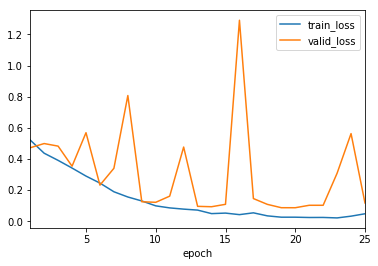

In [109]:
summary_stats.plot(x='epoch')